# Week 4 Homework

## Dataset
In this homework, we will use Credit Card Data from book "Econometric Analysis".

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv):



In [1]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column `card`).

## Preparation
- Create the target variable by mapping yes to 1 and no to 0.
-  Split the dataset into 3 parts: `train/validation/test` with `60%/20%/20%` distribution. Use train_test_split funciton for that with `random_state=1`.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from tqdm.auto import tqdm

In [3]:
df = pd.read_csv("AER_credit_card_data.csv")
df.shape

(1319, 12)

In [4]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [5]:
df["card"] = (df["card"] == "yes").astype("int")
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [7]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

### Question 1
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score and compute AUC with the `card` variable.
- Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share`

In [8]:
numerical = ["reports" , "age", "income", "share", "expenditure", "dependents", "months", "active"]
categorical = ["owner", "selfemp","majorcards"]

In [9]:
auc_scores = []

for var in numerical:
    dv = DictVectorizer(sparse=False)

    train_dict = df_train[categorical + [var]].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    # val_dict = df_val[categorical + numerical].to_dict(orient='records')
    # X_val = dv.transform(val_dict)

    y_pred = model.predict_proba(X_train)[:, 1]
    auc_score = roc_auc_score(y_train, y_pred)
    if auc_score < 0.5:
        auc_score = -(auc_score)
    
    auc_scores.append((var, auc_score))

sorted(auc_scores, key=lambda x: -x[1])

[('expenditure', 0.9927952299453431),
 ('share', 0.8611080439463369),
 ('reports', 0.7750142623162002),
 ('age', 0.6344476342958096),
 ('dependents', 0.6331456228491507),
 ('months', 0.6310798873737095),
 ('active', 0.6302011446658938),
 ('income', 0.6235898709950496)]

## Training the model

From now on, use these columns only:
```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

- Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

### Question 2
What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995

In [10]:
cols = ["reports", "age", "income", "share", "expenditure", "dependents", 
        "months", "majorcards", "active", "owner", "selfemp"]

In [11]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[cols].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[cols].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [12]:
dv, model = train(df_train, y_train)
y_pred = predict(df_val, dv, model)
auc_score = roc_auc_score(y_val, y_pred).round(3)
auc_score

0.995

### Question 3
Now let's compute precision and recall for our model.

- Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

- 0.1
- 0.3
- 0.6
- 0.8

In [13]:
thresholds = np.arange(0.0, 1.0, 0.01)
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [14]:
precisions = []
recalls = []

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    precisions.append(p)
    recalls.append(r)

In [15]:
precisions[:10]

[0.7992424242424242,
 0.8612244897959184,
 0.871900826446281,
 0.8978723404255319,
 0.9055793991416309,
 0.9055793991416309,
 0.9173913043478261,
 0.9173913043478261,
 0.9210526315789473,
 0.9210526315789473]

In [16]:
recalls[:10]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.995260663507109, 0.995260663507109]

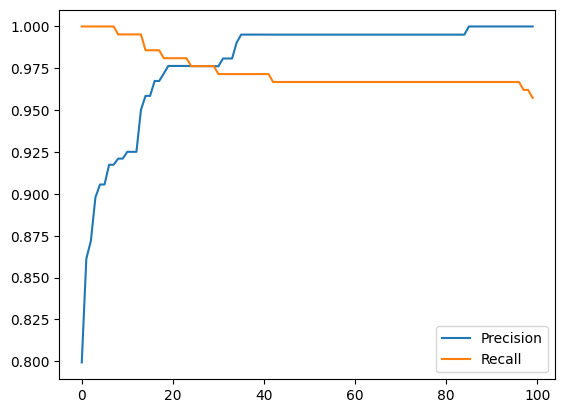

In [17]:
plt.plot(precisions, label='Precision')
plt.plot(recalls, label='Recall')
plt.legend();

### Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing $F_1$:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7

In [18]:
f1_scores = []
for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f1_score = 2 * ((p * r) / (p + r))
    f1_scores.append((round(t, 2), f1_score))

sorted(f1_scores, key=lambda x: -x[1])[:10]

[(0.35, 0.9832134292565947),
 (0.36, 0.9832134292565947),
 (0.37, 0.9832134292565947),
 (0.38, 0.9832134292565947),
 (0.39, 0.9832134292565947),
 (0.4, 0.9832134292565947),
 (0.41, 0.9832134292565947),
 (0.85, 0.983132530120482),
 (0.86, 0.983132530120482),
 (0.87, 0.983132530120482)]

### Question 5
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

```python
KFold(n_splits=5, shuffle=True, random_state=1)
```

- Iterate over different folds of `df_full_train`
- Split the data into train and validation
- Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
- Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24

In [19]:
n_splits = 5

scores = []
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0it [00:00, ?it/s]

0.996 +- 0.003


### Question 6
Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: `[0.01, 0.1, 1, 10]`
- Initialize `KFold` with the same parameters as previously
- Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [20]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.992 +- 0.006
C=0.1 0.995 +- 0.004
C=1 0.996 +- 0.003
C=10 0.996 +- 0.003


In [21]:
scores

[0.9934939091915835,
 0.9942401960784313,
 0.9945981554677206,
 0.9996107939802803,
 1.0]